<a href="https://colab.research.google.com/github/Wonny0120/portfolio/blob/main/Combined_Model_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==1.5.2
!pip install contextily geopandas

DOWNLOAD FROM THIS LINK:

---


 https://earth.google.com/earth/d/1onc8enQri0Ov-csEaXibuVdAwOmUsQbF?usp=sharing


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

In [ ]:
import fiona
from shapely.geometry import Point
from shapely.geometry import LineString
import geopandas as gpd


# --- 2. PROCESS THE KML PATHS ---
fiona.drvsupport.supported_drivers['KML'] = 'rw'
kml_shore_gdf = gpd.read_file('big_lake_coords.kml', driver='KML').to_crs(epsg=3857)


# --- 4. CALCULATE DISTANCE FOR HOUSES ---
house_df = housing
house_df.columns = house_df.columns.str.strip()

houses_gdf = gpd.GeoDataFrame(
    house_df,
    geometry=gpd.points_from_xy(house_df['long'], house_df['lat']),
    crs="EPSG:4326"
).to_crs(epsg=3857)


# Combine all lake geometries into one single object
lake_geometry = kml_shore_gdf.geometry.unary_union

# Calculate distance from each house point to that single object
house_df['dist_to_water_m'] = houses_gdf.geometry.distance(lake_geometry)
house_df['bedrooms'] = housing.bedrooms.replace(33,3)

/tmp/ipython-input-2193920127.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lake_geometry = kml_shore_gdf.geometry.unary_union


In [ ]:
businesses = {
    'microsoft':  [(47.645, -122.130)],
    'amazon':     [(47.622, -122.336)],
    'google':     [(47.624, -122.334)],
    'facebook':   [(47.621, -122.178)],
    'tesla':      [(47.612, -122.197)],
    'valve':      [(47.613, -122.200)],
    'uni-wa':     [(47.656, -122.306)]
}

# Create business points
business_points = []
for name, coords_list in businesses.items():
    for lat, lon in coords_list:
        business_points.append(Point(lon, lat))

businesses_gdf = gpd.GeoDataFrame(
    geometry=business_points,
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Distance to nearest business
business_geometry = businesses_gdf.geometry.union_all()
house_df['dist_to_business_m'] = houses_gdf.geometry.distance(business_geometry)

# Business accessibility score
house_df['business_access_score'] = 0.0
for name, coords_list in businesses.items():
    lat, lon = coords_list[0]
    business_point = gpd.GeoSeries(
        [Point(lon, lat)],
        crs="EPSG:4326"
    ).to_crs(epsg=3857).iloc[0]

    distances = houses_gdf.geometry.distance(business_point)
    house_df['business_access_score'] += 1 / (distances / 1000 + 0.5)

In [ ]:
# Separate features and target
cols = list(house_df.columns)

# Move 'dist_to_water_m' to the front
cols.insert(0, cols.pop(cols.index('grade')))
cols.insert(1, cols.pop(cols.index("sqft_living")))
house_df = house_df[cols]
X = house_df.drop(columns=["price", "date","floors", "bathrooms", 'dist_to_business_m'])
y = house_df["price"]
# One-hot encode categoricals
# X['zipcode'] = X['zipcode'].astype(str)
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Build model
model = XGBRegressor(
    n_estimators=750,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train
model.fit(X_train_scaled, y_train)

# Predict
preds = model.predict(X_test_scaled)


In [ ]:
# Metrics
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2:", r2)


RMSE: 120136.7939998637
R2: 0.904303105127123


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
importances = model.feature_importances_

feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feat_imp

,feature,importance
0,grade,0.280504
5,waterfront,0.167864
1,sqft_living,0.149241
6,view,0.083438
18,business_access_score,0.071152
13,lat,0.068167
15,sqft_living15,0.030238
14,long,0.027302
8,sqft_above,0.020714
17,dist_to_water_m,0.020631


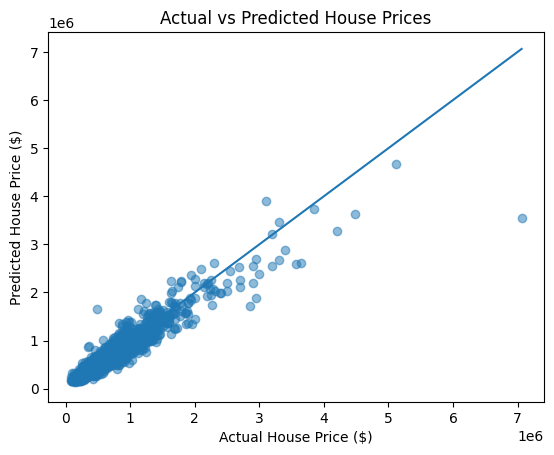

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual House Price ($)")
plt.ylabel("Predicted House Price ($)")
plt.title("Actual vs Predicted House Prices")

plt.show()

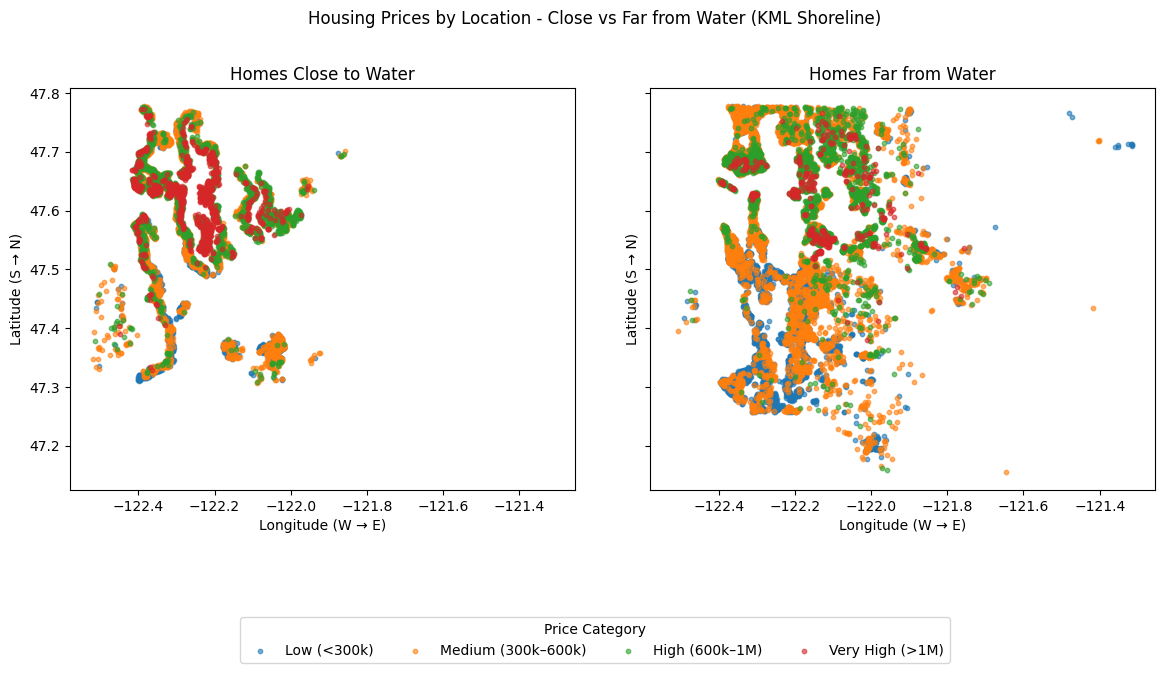

In [ ]:
# Distance cutoff (meters)
cutoff = 2000

# Create close/far groups
housing["water_group"] = housing["dist_to_water_m"].apply(
    lambda x: "Close to Water (<1km)" if x <= cutoff else "Far from Water (>1km)"
)

# Price bands
housing["price_band"] = pd.cut(
    housing["price"],
    bins=[0, 300000, 600000, 1000000, np.inf],
    labels=["Low (<300k)", "Medium (300k–600k)", "High (600k–1M)", "Very High (>1M)"]
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

for ax, group, title in zip(
    axes,
    ["Close to Water (<1km)", "Far from Water (>1km)"],
    ["Homes Close to Water", "Homes Far from Water"]
):
    sub = housing[housing["water_group"] == group]

    for band in housing["price_band"].cat.categories:
        ssub = sub[sub["price_band"] == band]
        ax.scatter(ssub["long"], ssub["lat"], s=10, alpha=0.6, label=str(band))

    ax.set_title(title)
    ax.set_xlabel("Longitude (W → E)")
    ax.set_ylabel("Latitude (S → N)")

# Shared legend below plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Price Category",
           loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.12))

fig.suptitle("Housing Prices by Location - Close vs Far from Water (KML Shoreline)", y=0.98)

# Replace tight_layout (prevents warning)
plt.subplots_adjust(top=0.85, bottom=0.18, wspace=0.15)

plt.show()


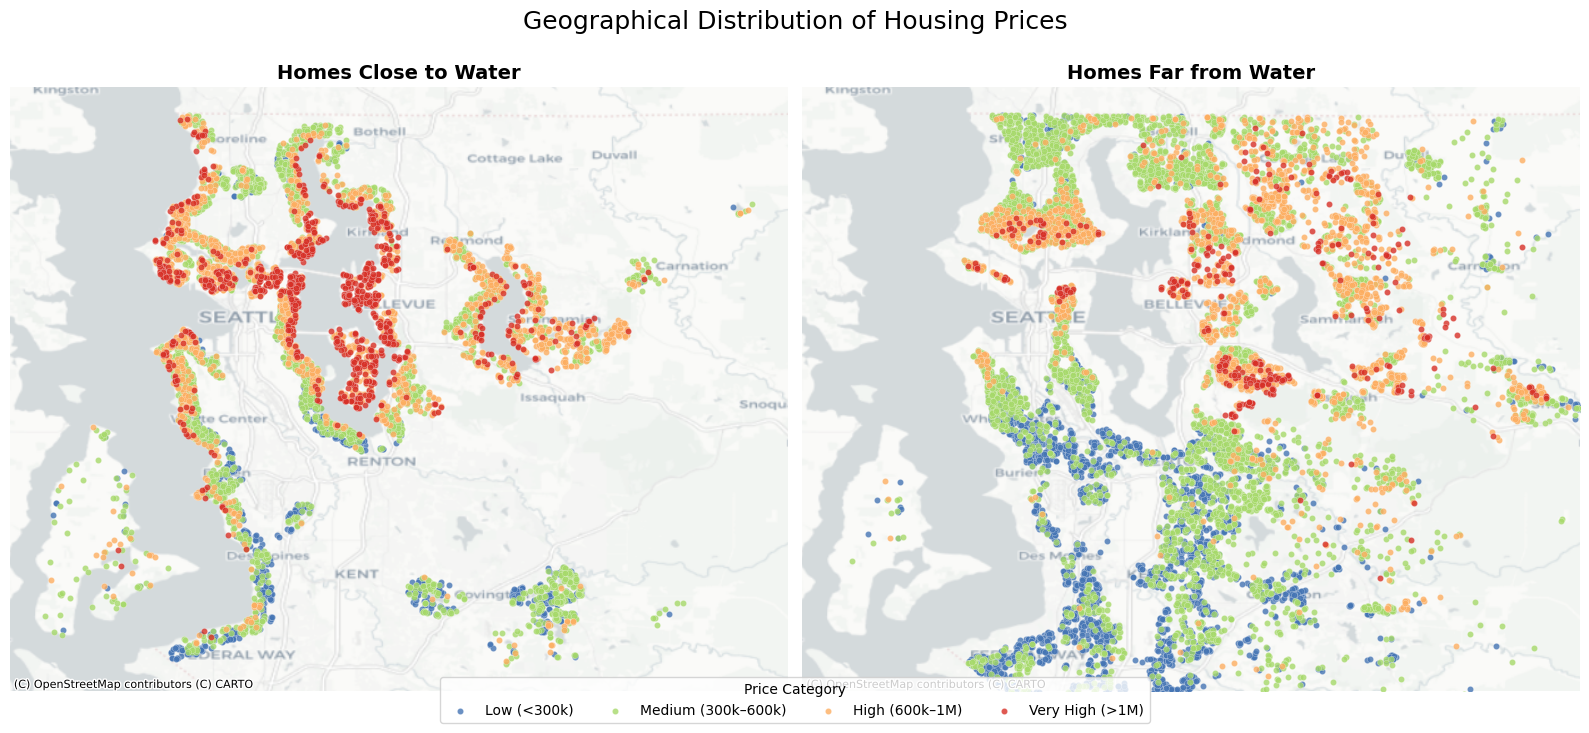

In [ ]:
import contextily as ctx
# 1. Setup colors (Darker = Expensive)
my_colors = ["#4575B4", "#A6D96A", "#FDAE61", "#D73027"]

# 2. Setup labels and bands (Keeping your logic)
housing["water_group"] = housing["dist_to_water_m"].apply(
    lambda x: "Close to Water (<2km)" if x <= 2000 else "Far from Water (>2km)"
)

housing["price_band"] = pd.cut(
    housing["price"],
    bins=[0, 300000, 600000, 1000000, np.inf],
    labels=["Low (<300k)", "Medium (300k–600k)", "High (600k–1M)", "Very High (>1M)"]
)

# 3. Build the Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

groups = ["Close to Water (<2km)", "Far from Water (>2km)"]
titles = ["Homes Close to Water", "Homes Far from Water"]

for ax, group, title in zip(axes, groups, titles):
    sub = housing[housing["water_group"] == group]

    for band, color in zip(housing["price_band"].cat.categories, my_colors):
        ssub = sub[sub["price_band"] == band]
        # Using zorder=2 to ensure points stay above the map
        ax.scatter(ssub["long"], ssub["lat"], s=20, alpha=0.8,
                   label=str(band), color=color, zorder=2, edgecolors='white', linewidth=0.2)

    # --- ADD THE MAP BACKGROUND ---
    # crs='EPSG:4326' tells contextily your data is in standard Lat/Long
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off') # Hide lat/long ticks for a cleaner 'map' look

# Legend and Titles
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Price Category",
           loc="lower center", ncol=4, bbox_to_anchor=(0.5, 0.05))

fig.suptitle("Geographical Distribution of Housing Prices", fontsize=18, y=0.95)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])

plt.show()

Calclating Businesses

In [ ]:
# === BUSINESS PROXIMITY FEATURES ===
businesses = {
    'microsoft':  [(47.645, -122.130)],
    'amazon':     [(47.622, -122.336)],
    'google':     [(47.624, -122.334)],
    'facebook':   [(47.621, -122.178)],
    'costco':     [(47.548, -122.050)],
    'valve':      [(47.613, -122.200)]
}

# Create business points
business_points = []
for name, coords_list in businesses.items():
    for lat, lon in coords_list:
        business_points.append(Point(lon, lat))

businesses_gdf = gpd.GeoDataFrame(
    geometry=business_points,
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Distance to nearest business
business_geometry = businesses_gdf.geometry.union_all()
house_df['dist_to_business_m'] = houses_gdf.geometry.distance(business_geometry)

# Business accessibility score
house_df['business_access_score'] = 0.0
for name, coords_list in businesses.items():
    lat, lon = coords_list[0]
    business_point = gpd.GeoSeries(
        [Point(lon, lat)],
        crs="EPSG:4326"
    ).to_crs(epsg=3857).iloc[0]

    distances = houses_gdf.geometry.distance(business_point)
    house_df['business_access_score'] += 1 / (distances / 1000 + 0.5)

/tmp/ipython-input-4056861124.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df['dist_to_business_m'] = houses_gdf.geometry.distance(business_geometry)
/tmp/ipython-input-4056861124.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df['business_access_score'] = 0.0
/tmp/ipython-input-4056861124.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

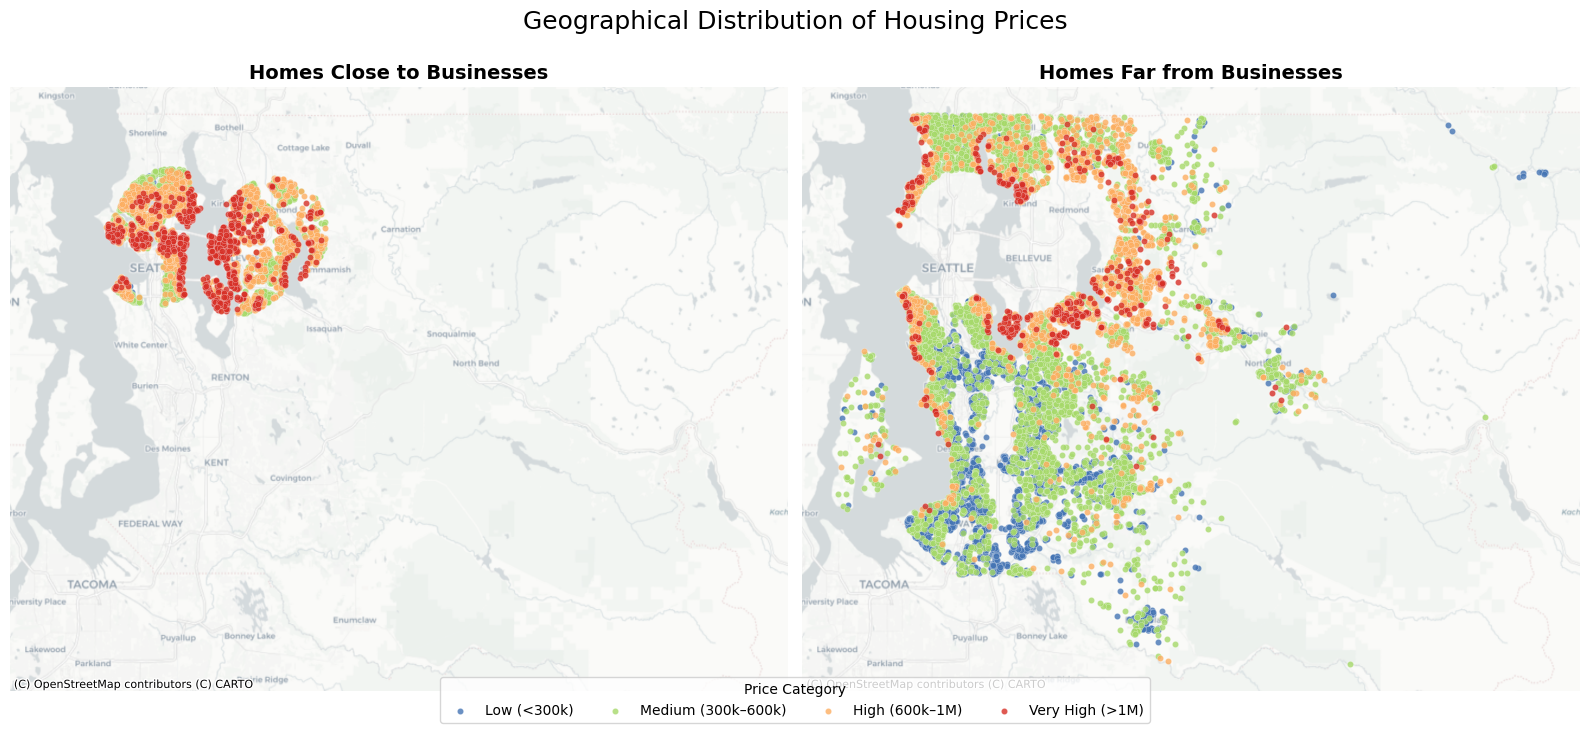

In [ ]:
# 1. Your original logic (Confirmed as working for your data)
housing["business_group"] = housing["dist_to_business_m"].apply(
    lambda x: "Close to Businesses (<10km)" if x >= 10000 else "Far from Businesses (>10km)"
)

housing["price_band"] = pd.cut(
    housing["price"],
    bins=[0, 300000, 600000, 1000000, np.inf],
    labels=["Low (<300k)", "Medium (300k–600k)", "High (600k–1M)", "Very High (>1M)"]
)

# 2. Build the Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

# --- LEFT PLOT: CLOSE TO BUSINESSES ---
ax_left = axes[1]
sub_close = housing[housing["business_group"] == "Close to Businesses (<10km)"]

for band, color in zip(housing["price_band"].cat.categories, my_colors):
    ssub = sub_close[sub_close["price_band"] == band]
    ax_left.scatter(ssub["long"], ssub["lat"], s=20, alpha=0.8,
                    label=str(band), color=color, zorder=2, edgecolors='white', linewidth=0.2)

ctx.add_basemap(ax_left, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
ax_left.set_title("Homes Far from Businesses", fontsize=14, fontweight='bold')
ax_left.axis('off')


# --- RIGHT PLOT: FAR FROM BUSINESSES ---
ax_right = axes[0]
sub_far = housing[housing["business_group"] == "Far from Businesses (>10km)"]

for band, color in zip(housing["price_band"].cat.categories, my_colors):
    ssub = sub_far[sub_far["price_band"] == band]
    ax_right.scatter(ssub["long"], ssub["lat"], s=20, alpha=0.8,
                     label=str(band), color=color, zorder=2, edgecolors='white', linewidth=0.2)

ctx.add_basemap(ax_right, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
ax_right.set_title("Homes Close to Businesses", fontsize=14, fontweight='bold')
ax_right.axis('off')


# 3. Legend and Global Titles
handles, labels = ax_left.get_legend_handles_labels()
fig.legend(handles, labels, title="Price Category",
           loc="lower center", ncol=4, bbox_to_anchor=(0.5, 0.05))

fig.suptitle("Geographical Distribution of Housing Prices", fontsize=18, y=0.95)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])

plt.show()

/tmp/ipython-input-184994062.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df["business_group"] = house_df["dist_to_business_m"].apply(
/tmp/ipython-input-184994062.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df["price_band"] = pd.cut(


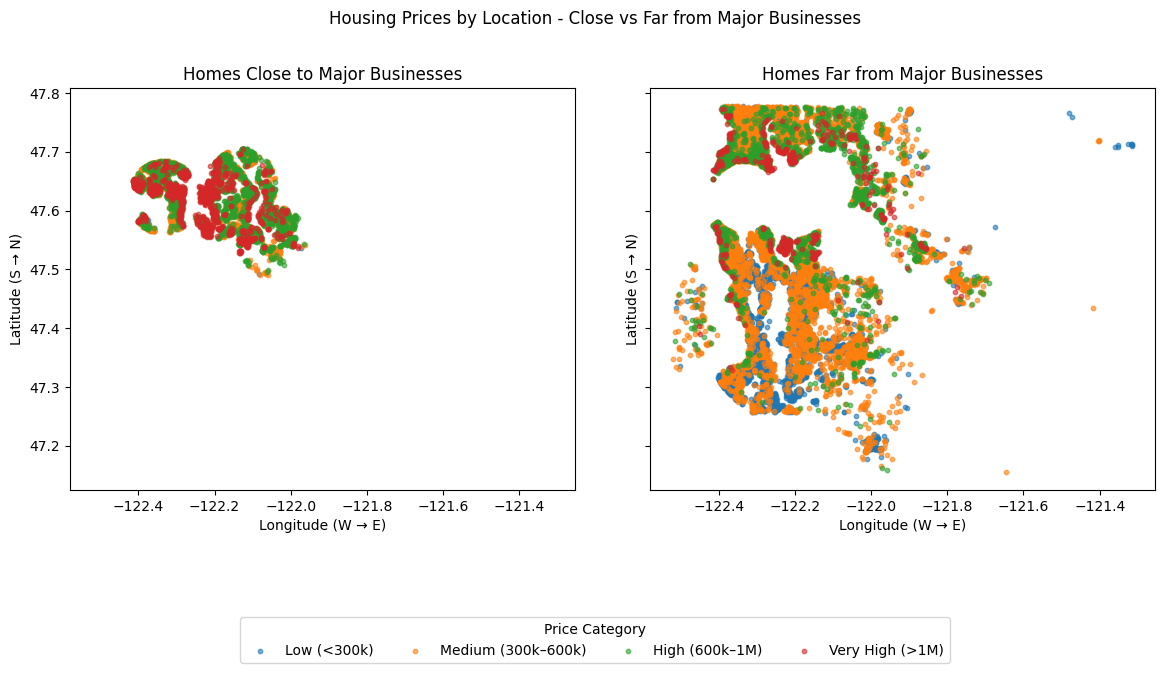

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Distance cutoff (meters) - 10km radius
cutoff = 10000

# Create close/far groups for businesses
house_df["business_group"] = house_df["dist_to_business_m"].apply(
    lambda x: "Close to Business (<10km)" if x <= cutoff else "Far from Business (>10km)"
)

# Price bands (reuse the same ones)
house_df["price_band"] = pd.cut(
    house_df["price"],
    bins=[0, 300000, 600000, 1000000, np.inf],
    labels=["Low (<300k)", "Medium (300k–600k)", "High (600k–1M)", "Very High (>1M)"]
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

for ax, group, title in zip(
    axes,
    ["Close to Business (<10km)", "Far from Business (>10km)"],
    ["Homes Close to Major Businesses", "Homes Far from Major Businesses"]
):
    sub = house_df[house_df["business_group"] == group]

    for band in house_df["price_band"].cat.categories:
        ssub = sub[sub["price_band"] == band]
        ax.scatter(ssub["long"], ssub["lat"], s=10, alpha=0.6, label=str(band))

    ax.set_title(title)
    ax.set_xlabel("Longitude (W → E)")
    ax.set_ylabel("Latitude (S → N)")

# Shared legend below plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Price Category",
           loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.12))

fig.suptitle("Housing Prices by Location - Close vs Far from Major Businesses", y=0.98)

plt.subplots_adjust(top=0.85, bottom=0.18, wspace=0.15)
plt.show()

In [ ]:
# Separate features and target
X_v2 = house_df.drop(columns=["price", "date", "floors", "bathrooms"])
y_v2 = house_df["price"]

# One-hot encode categoricals
X_v2 = pd.get_dummies(X_v2, drop_first=True)

# Train/test split
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_v2, y_v2, test_size=0.2, random_state=42
)

# Scale features
scaler_v2 = MinMaxScaler()
X_train_scaled_v2 = scaler_v2.fit_transform(X_train_v2)
X_test_scaled_v2 = scaler_v2.transform(X_test_v2)

# Build model v2
model_v2 = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=1
)

# Train
model_v2.fit(X_train_scaled_v2, y_train_v2)

# Predict
preds_v2 = model_v2.predict(X_test_scaled_v2)

# Metrics
rmse_v2 = mean_squared_error(y_test_v2, preds_v2, squared=False)
r2_v2 = r2_score(y_test_v2, preds_v2)

print("MODEL V2 (With Business Features):")
print(f"RMSE: {rmse_v2:,.2f}")
print(f"R²: {r2_v2:.4f}")

# Feature importance
importances_v2 = model_v2.feature_importances_

feat_imp_v2 = pd.DataFrame({
    "feature": X_v2.columns,
    "importance": importances_v2
}).sort_values(by="importance", ascending=False)

MODEL V2 (With Business Features):
RMSE: 107,345.77
R²: 0.9236


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Holdout Data

In [ ]:
# Load the new holdout dataset
# holdout_data = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')
holdout_data = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')

# Create a copy and clean column names
holdout_df = holdout_data.copy()
holdout_df.columns = holdout_df.columns.str.strip()

holdout_data.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [ ]:
# === CALCULATE DISTANCE TO WATER FOR HOLDOUT DATA ===
holdout_gdf = gpd.GeoDataFrame(
    holdout_df,
    geometry=gpd.points_from_xy(holdout_df['long'], holdout_df['lat']),
    crs="EPSG:4326"
).to_crs(epsg=3857)

holdout_df['dist_to_water_m'] = holdout_gdf.geometry.distance(lake_geometry)

# === CALCULATE DISTANCE TO BUSINESSES FOR HOLDOUT DATA ===
holdout_df['dist_to_business_m'] = holdout_gdf.geometry.distance(business_geometry)

holdout_df['business_access_score'] = 0.0
for name, coords_list in businesses.items():
    lat, lon = coords_list[0]
    business_point = gpd.GeoSeries(
        [Point(lon, lat)],
        crs="EPSG:4326"
    ).to_crs(epsg=3857).iloc[0]

    distances = holdout_gdf.geometry.distance(business_point)
    holdout_df['business_access_score'] += 1 / (distances / 1000 + 0.5)

holdout_df['bedrooms'] = holdout_df['bedrooms'].replace(33, 3)

# === PREPARE FEATURES ===
X_holdout = holdout_df.drop(columns=["date","floors", "bathrooms", 'dist_to_business_m'])
X_holdout = pd.get_dummies(X_holdout, drop_first=True)
X_holdout = X_holdout.reindex(columns=X.columns, fill_value=0)
X_holdout_scaled = scaler.transform(X_holdout)

# === MAKE PREDICTIONS ===
holdout_preds = model.predict(X_holdout_scaled)

print("holdout_preds")

# Add predictions to the dataframe
holdout_df['predicted_price'] = holdout_preds

# holdout_preds
holdout_df[["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "condition", "grade", "yr_built", "yr_renovated","lat", "long", "zipcode", "predicted_price"]]

holdout_preds


,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,yr_built,yr_renovated,lat,long,zipcode,predicted_price
0,4,2.25,2070,8893,4,8,1986,0,47.4388,-122.162,98058,3.875577e+05
1,5,3.00,2900,6730,5,8,1977,0,47.6784,-122.285,98115,7.106938e+05
2,4,2.50,3770,10893,3,11,1997,0,47.5646,-122.129,98006,1.134045e+06
3,3,3.50,4560,14608,3,12,1990,0,47.6995,-122.228,98034,1.559520e+06
4,3,2.50,2550,5376,3,9,2004,0,47.6647,-122.083,98052,6.813589e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
1608,3,1.75,2160,5760,4,8,1954,0,47.5346,-122.391,98136,6.117904e+05
1609,4,2.50,2220,4228,3,8,2014,0,47.5014,-122.341,98146,4.455656e+05
1610,3,1.75,1390,8980,4,8,1985,0,47.2015,-122.005,98022,2.748973e+05
1611,3,2.25,2930,6000,3,11,2000,0,47.6301,-122.301,98112,1.187869e+06


In [ ]:
holdout_preds

array([ 387557.7 ,  710693.75, 1134045.2 , ...,  274897.3 , 1187869.4 ,
        292851.4 ], dtype=float32)

In [ ]:
h_answer = pd.DataFrame(holdout_preds)

,0
0,3.875577e+05
1,7.106938e+05
2,1.134045e+06
3,1.559520e+06
4,6.813589e+05
...,...
1608,6.117904e+05
1609,4.455656e+05
1610,2.748973e+05
1611,1.187869e+06


In [ ]:
h_answer.to_csv("team6-module3-predictions.csv", index=False)